In [288]:
#تعريف المكتبات
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [289]:
#تحميل البيانات
#step1:upload csv file
!gdown --id 1-35o0bOMgXOZT86Q4MXgom6WJlWhnL8S
df = pd.read_csv('boat_data.csv')

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:139: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-35o0bOMgXOZT86Q4MXgom6WJlWhnL8S
To: /content/boat_data.csv
100% 1.15M/1.15M [00:00<00:00, 142MB/s]


In [290]:
# تنظيف عمود Price وتحويله لرقم بطريقة آمنة

# نحوله لنص أولاً
df["Price"] = df["Price"].astype(str)

# نحذف أي شيء غير رقم أو نقطة
df["Price"] = df["Price"].str.replace(r"[^0-9.]", "", regex=True)

# نحوله لرقم
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")

In [291]:
df["Price"].dtype

dtype('int64')

In [292]:
# عرض أول 5 صفوف
df.head()

Price            Boat Type          Manufacturer                 Type  \
0   3337          Motor Yacht  Rigiflex power boats  new boat from stock   
1   3490  Center console boat     Terhi power boats  new boat from stock   
2   3770           Sport Boat    Marine power boats  new boat from stock   
3  25900           Sport Boat    Pioner power boats  new boat from stock   
4   3399         Fishing Boat    Linder power boats  new boat from stock   

   Year Built  Length  Width       Material  \
0        2017    4.00   1.90            NaN   
1        2020    4.00   1.50  Thermoplastic   
2           0    3.69   1.42      Aluminium   
3        2020    3.00   1.00            NaN   
4        2019    3.55   1.46      Aluminium   

                                     Location  Number of views last 7 days  
0      Switzerland Â» Lake Geneva Â» VÃ©senaz                          226  
1                    Germany Â» BÃ¶nningstedt                           75  
2  Switzerland Â» Lake of Zurich Â» StÃ¤fa ZH                          124  
3                        Denmark Â» Svendborg                           64  
4               Germany Â» Bayern Â» MÃ¼nchen                           58

In [293]:
# معرفة أنواع البيانات وعدد القيم غير الفارغة
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9888 entries, 0 to 9887
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Price                        9888 non-null   int64  
 1   Boat Type                    9888 non-null   object 
 2   Manufacturer                 8550 non-null   object 
 3   Type                         9882 non-null   object 
 4   Year Built                   9888 non-null   int64  
 5   Length                       9879 non-null   float64
 6   Width                        9832 non-null   float64
 7   Material                     8139 non-null   object 
 8   Location                     9852 non-null   object 
 9   Number of views last 7 days  9888 non-null   int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 772.6+ KB


In [294]:
# عرض الإحصائيات العامة
df.describe()

Price   Year Built       Length        Width  \
count  9.888000e+03  9888.000000  9879.000000  9832.000000   
mean   3.201373e+05  1893.192860    11.570017     3.520124   
std    1.007482e+06   460.201582     6.002820     1.220534   
min    3.300000e+03     0.000000     1.040000     0.010000   
25%    4.400000e+04  1996.000000     7.470000     2.540000   
50%    9.500000e+04  2007.000000    10.280000     3.330000   
75%    2.550000e+05  2017.000000    13.930000     4.250000   
max    3.100000e+07  2021.000000   100.000000    25.160000   

       Number of views last 7 days  
count                  9888.000000  
mean                    149.160801  
std                     151.819752  
min                      13.000000  
25%                      70.000000  
50%                     108.000000  
75%                     172.000000  
max                    3263.000000

In [295]:
# التحقق من القيم المفقودة
df.isnull().sum()

Price                             0
Boat Type                         0
Manufacturer                   1338
Type                              6
Year Built                        0
Length                            9
Width                            56
Material                       1749
Location                         36
Number of views last 7 days       0
dtype: int64

In [296]:
#  تحديد العمود الهدف
y = df["Price"]

In [297]:
#  تحديد الأعمدة المستخدمة كميزات
X = df.drop("Price", axis=1)

In [298]:
# تعويض القيم المفقودة بالمتوسط
df = df.fillna(df.mean(numeric_only=True))

# التأكد بعد التعويض
df.isnull().sum()

Price                             0
Boat Type                         0
Manufacturer                   1338
Type                              6
Year Built                        0
Length                            0
Width                             0
Material                       1749
Location                         36
Number of views last 7 days       0
dtype: int64

In [299]:
# حذف القيم المكررة
df = df.drop_duplicates()

# التأكد من عدم وجود تكرار
df.duplicated().sum()

np.int64(0)

In [300]:
# discover data after cleaning
df.shape

(9888, 10)

In [301]:
# حذف القيم الشاذة باستخدام IQR

# Select only numeric columns for outlier detection
numeric_cols = df.select_dtypes(include=np.number).columns

# Calculate Q1 and Q3 for these numeric columns
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)

IQR = Q3 - Q1

# Define bounds for these numeric columns
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify rows where *any* numeric column has an outlier
outlier_mask = ((df[numeric_cols] < lower_bound) | (df[numeric_cols] > upper_bound)).any(axis=1)

# Filter the original DataFrame, keeping rows that are NOT outliers
df = df[~outlier_mask]

# عرض حجم البيانات بعد حذف القيم الشاذة
df.shape

(7363, 10)

In [302]:
# تحسين البيانات - تحويل Year Built إلى Boat Age
if 'Year Built' in df.columns:
    df['Boat Age'] = 2026 - df['Year Built']
    df.drop('Year Built', axis=1, inplace=True)
else:
    print("'Year Built' column not found. It might have been processed already or is missing from the DataFrame.")

In [303]:
# Feature Engineering: Log Transformation لعدد المشاهدات لتقليل skewness
import numpy as np

# تحسين البيانات - تحويل Number of views last 7 days باستخدام لوغاريتم
df['Number of views last 7 days'] = np.log1p(df['Number of views last 7 days'])

In [304]:
#تعويض الأرقام بالمتوسط
df = df.fillna(df.mean(numeric_only=True))

In [305]:
# حذف القيم المكررة
df = df.drop_duplicates()

In [306]:
# تعويض القيم المفقودة بالمتوسط
df = df.fillna(df.mean(numeric_only=True))

In [307]:
# تحويل الأعمدة النصية إلى رقمية
X = pd.get_dummies(X, drop_first=True)

In [308]:
#فحص الانحراف المعياري
df.describe()

Price       Length        Width  Number of views last 7 days  \
count    7363.000000  7363.000000  7363.000000                  7363.000000   
mean   136274.555752    10.395336     3.327642                     4.634181   
std    126243.747258     3.695796     0.884018                     0.570127   
min      3300.000000     1.150000     0.500000                     2.772589   
25%     44500.000000     7.470000     2.540000                     4.234107   
50%     87000.000000     9.990000     3.250000                     4.653960   
75%    195000.000000    12.900000     4.000000                     5.049856   
max    570000.000000    23.350000     6.720000                     5.786897   

          Boat Age  
count  7363.000000  
mean     19.378922  
std      12.106130  
min       5.000000  
25%       8.000000  
50%      18.000000  
75%      26.000000  
max      61.000000

In [309]:
# توحيد القيم العددية
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [310]:
type(X)

numpy.ndarray

In [311]:
X = df.drop("Price", axis=1)
y = df["Price"]

In [312]:
X = pd.get_dummies(X, drop_first=True)

In [313]:
# تقسيم البيانات
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

In [314]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [315]:
# تدريب النموذج الأول
model1 = LinearRegression()
model1.fit(X_train, y_train)

LinearRegression()

In [316]:
# التنبؤ باستخدام النموذج الأول
pred1 = model1.predict(X_test)

In [317]:
# تقييم النموذج الأول
r2_1 = r2_score(y_test, pred1)
mae_1 = mean_absolute_error(y_test, pred1)
mse_1 = mean_squared_error(y_test, pred1)
print("R2:", r2_1)
print("MAE:", mae_1)
print("MSE:", mse_1)

# حساب RMSE
rmse_1 = np.sqrt(mse_1)
print("RMSE:", rmse_1)

R2: 0.673687474967351
MAE: 50706.390575817844
MSE: 5152359036.535735
RMSE: 71779.9347766194


In [318]:
# تقييم النموذج الأول
print("تقييم النموذج الأول:")

if r2_1 > 0.7:
    print("النموذج جيد")
elif r2_1 > 0.4:
    print("النموذج متوسط")
else:
    print("النموذج ضعيف ويحتاج تحسين")

تقييم النموذج الأول:
النموذج متوسط


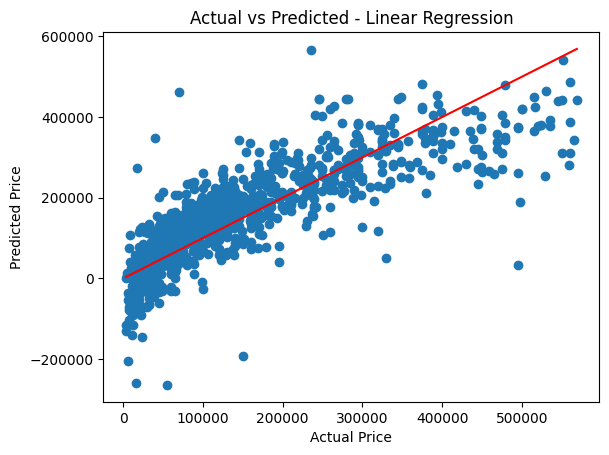

In [319]:
# رسم مقارنة بين السعر الحقيقي والسعر المتوقع

plt.figure()

plt.scatter(y_test, pred1)

# رسم الخط المثالي للمقارنة
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red')

plt.xlabel("Actual Price")

plt.ylabel("Predicted Price")

plt.title("Actual vs Predicted - Linear Regression")

plt.show()

In [321]:
# حفظ النسخة المحسنة

df.to_csv("boat_data_initial.csv", index=False)